In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

Загружаем датасет по ссылке

In [35]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"

# Названия колонок
columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
           'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
           'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
           'Horizontal_Distance_To_Fire_Points'] + ['Wilderness_Area_{}'.format(i) for i in range(1, 5)] + \
          ['Soil_Type_{}'.format(i) for i in range(1, 41)] + ['Cover_Type']

# Загрузка датасета в Pandas DataFrame
df = pd.read_csv(url, header=None, names=columns)

# Проверка корректности загрузки
print(df.head())

   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238   

Разделяем датасет Положительный класс – 3, Отрицательный класс – 1, 2, 4, 5, 6, 7

In [36]:
df.loc[(df['Cover_Type'] == 1) | (df['Cover_Type'] == 2) | (df['Cover_Type'] == 4) | (df['Cover_Type'] == 5) | (df['Cover_Type'] == 6) | (df['Cover_Type'] == 7), 'Cover_Type'] = 1
df.loc[df['Cover_Type'] == 3, 'Cover_Type'] = 0
df['Cover_Type'].value_counts()

1    545258
0     35754
Name: Cover_Type, dtype: int64

Уменьшенный датасет для тестов

In [37]:
from sklearn.utils import resample
df_smaller = resample(df, n_samples=10000)
df_smaller['Cover_Type'].value_counts()

1    9398
0     602
Name: Cover_Type, dtype: int64

Разделяем датасет на столбец значений, которые бдуем предсказывать, и на всё остальное

In [38]:
dfX = df_smaller.drop(['Cover_Type'],axis=1)
dfY = df_smaller['Cover_Type']

Делим датасет на тестовую и трейновую выборку

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(dfX, dfY, test_size=0.3, stratify=dfY,
                                                    random_state=1)
X_train_unbalanced, X_test_unbalanced, Y_train_unbalanced, Y_test_unbalanced = train_test_split(dfX, dfY, test_size=0.3, random_state=1)

In [40]:
from sklearn.model_selection import GridSearchCV

Создаем модель RandomForest

In [41]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
parameters ={'max_depth':[3,5,10,None],
              'n_estimators':[10,100,200],
              'max_features':[1,3,5,7],
              'min_samples_leaf':[1,2,3],
              'min_samples_split':[1,2,3]}
gridForest = GridSearchCV(estimator=model, param_grid = parameters, n_jobs = -1)
gridForest.fit(X_train, Y_train)
print('Best hyperparameters are: '+str(gridForest.best_params_))
print('Best score is: '+str(gridForest.best_score_))
bestRFClassifier = gridForest.best_estimator_
y_pred_RFClassifier = bestRFClassifier.predict(X_test)
print(classification_report(y_true=Y_test,y_pred=y_pred_RFClassifier))

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/utils/

Best hyperparameters are: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score is: 0.975
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       181
           1       0.99      0.98      0.99      2819

    accuracy                           0.97      3000
   macro avg       0.88      0.89      0.88      3000
weighted avg       0.97      0.97      0.97      3000



In [42]:
gridUnbalancedForest = GridSearchCV(estimator=model, param_grid = parameters, n_jobs = -1)
gridUnbalancedForest.fit(X_train_unbalanced, Y_train_unbalanced)
bestUnbalancedRFClassifier = gridForest.best_estimator_

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/utils/

ROC кривая для RandomForestClassifier

In [43]:
probsBestRFClassifier = bestRFClassifier.predict_proba(X_test)
predsBestRFClassifier = probsBestRFClassifier[:,1]
fprBestRFClassifier, tprBestRFClassifier, threshouldBestRFClassifier = roc_curve(Y_test, predsBestRFClassifier)
roc_aucBestRFClassifier = auc(fprBestRFClassifier,tprBestRFClassifier)
print('AUC = %.3f'%roc_aucBestRFClassifier)

AUC = 0.989


Создаем модель LogisticRegression 

In [44]:
from sklearn.linear_model import LogisticRegression

logRegModel = LogisticRegression()
logRegParameters = {'C':[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
gridLogReg = GridSearchCV(estimator=logRegModel, param_grid=logRegParameters, n_jobs = -1)
gridLogReg.fit(X_train, Y_train)
print('Best hyperparameters are: '+str(gridLogReg.best_params_))
print('Best score is: '+str(gridLogReg.best_score_))
#Вибираем лучшую модель из подбора как основную
bestLogRegModel = gridLogReg.best_estimator_
y_pred_bestLogReg = bestLogRegModel.predict(X_test)
print(classification_report(y_true=Y_test,y_pred=y_pred_bestLogReg))

Best hyperparameters are: {'C': 1.0}
Best score is: 0.9575714285714285
              precision    recall  f1-score   support

           0       0.64      0.51      0.57       181
           1       0.97      0.98      0.98      2819

    accuracy                           0.95      3000
   macro avg       0.81      0.75      0.77      3000
weighted avg       0.95      0.95      0.95      3000



/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [45]:
gridUnbalancedLogReg = GridSearchCV(estimator=logRegModel, param_grid = logRegParameters, n_jobs = -1)
gridUnbalancedLogReg.fit(X_train_unbalanced, Y_train_unbalanced)
bestUnbalancedLogRegModel = gridUnbalancedLogReg.best_estimator_

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC кривая для LogisticRegression

In [46]:
probsBestLogReg = bestLogRegModel.predict_proba(X_test)
predsBestLogReg = probsBestLogReg[:,1]
fprBestLogReg, tprBestLogReg, threshouldBestLogReg = roc_curve(Y_test, predsBestLogReg)
roc_aucBestLogReg = auc(fprBestLogReg,tprBestLogReg)
print('AUC = %.3f'%roc_aucBestLogReg)

AUC = 0.975


Создаем модель XGBoost

In [47]:
from xgboost import XGBClassifier

XGBClassifierModel = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42)

XGBClassifierParameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]}

gridXGBClassifier = GridSearchCV(estimator=XGBClassifierModel, param_grid=XGBClassifierParameters, n_jobs = -1)
gridXGBClassifier.fit(X_train, Y_train)
print('Best hyperparameters are: '+str(gridXGBClassifier.best_params_))
print('Best score is: '+str(gridXGBClassifier.best_score_))
bestXGBClassifierModel = gridXGBClassifier.best_estimator_
y_pred_bestXGBClassifier = bestXGBClassifierModel.predict(X_test)
print(classification_report(y_true=Y_test,y_pred=y_pred_bestXGBClassifier))

Best hyperparameters are: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 180}
Best score is: 0.975
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       181
           1       0.98      0.98      0.98      2819

    accuracy                           0.97      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.97      0.97      0.97      3000



ROC кривая для XGBClassifier

In [48]:
probsBestXGBClassifier = bestXGBClassifierModel.predict_proba(X_test)
predsBestLogReg = probsBestXGBClassifier[:,1]
fprBestXGBClassifier, tprBestXGBClassifier, threshouldBestXGBClassifier = roc_curve(Y_test, predsBestLogReg)
roc_aucBestXGBClassifier = auc(fprBestXGBClassifier,tprBestXGBClassifier)
print('AUC = %.3f'%roc_aucBestXGBClassifier)

AUC = 0.988


Вывад ROC кривых для всех моделей

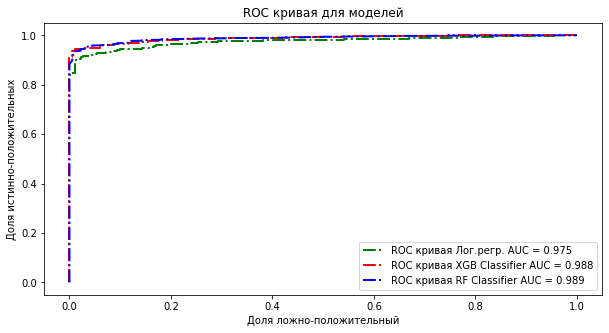

In [49]:
plt.figure(figsize=(10,5))
plt.title('ROC кривая для моделей')
plt.plot(fprBestLogReg, tprBestLogReg, color ='green', linestyle='-.',
         linewidth=2,label='ROC кривая Лог.регр. AUC = %.3f'%roc_aucBestLogReg)
plt.plot(fprBestXGBClassifier, tprBestXGBClassifier, color ='red', linestyle='-.',
         linewidth=2,label='ROC кривая XGB Classifier AUC = %.3f'%roc_aucBestXGBClassifier)
plt.plot(fprBestRFClassifier, tprBestRFClassifier, color ='blue', linestyle='-.',
         linewidth=2,label='ROC кривая RF Classifier AUC = %.3f'%roc_aucBestRFClassifier)
plt.legend(loc='lower right')
plt.xlabel('Доля ложно-положительный')
plt.ylabel('Доля истинно-положительных')
plt.show()

Визуализация важности признаков для моделей RF и LR (для сбалансированной выборки)

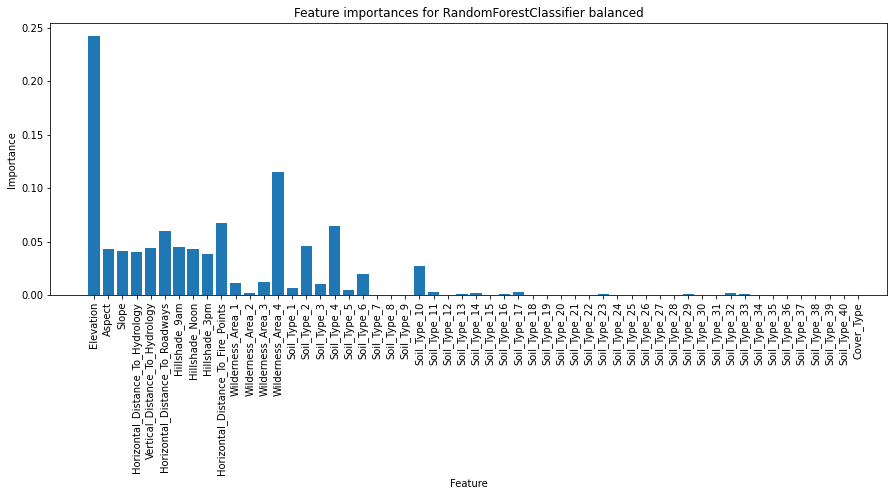

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.title("Feature importances for RandomForestClassifier balanced")
plt.bar(range(len(bestRFClassifier.feature_importances_)), bestRFClassifier.feature_importances_)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

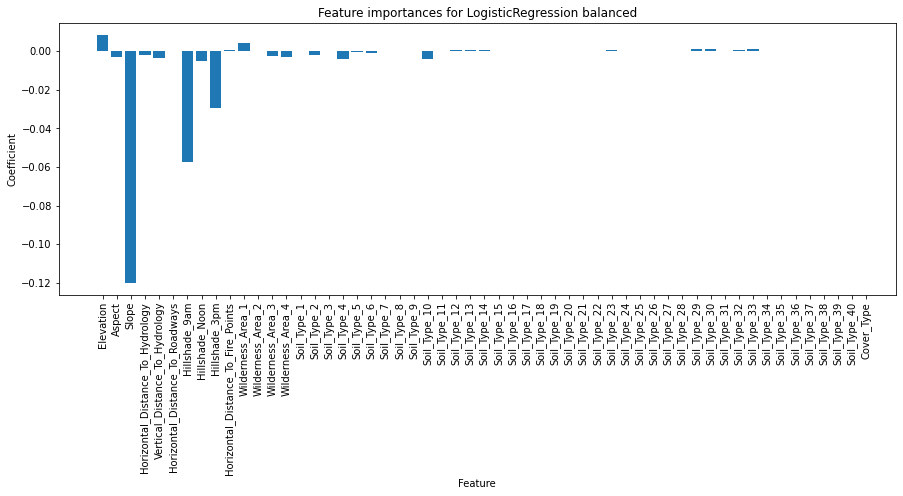

In [51]:
plt.figure(figsize=(15,5))
plt.title("Feature importances for LogisticRegression balanced")
plt.bar(range(len(bestLogRegModel.coef_[0])), bestLogRegModel.coef_[0])
plt.xticks(range(len(columns)),columns, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.show()

Визуализация важности признаков для моделей RF и LR (для первоначальной выборки)

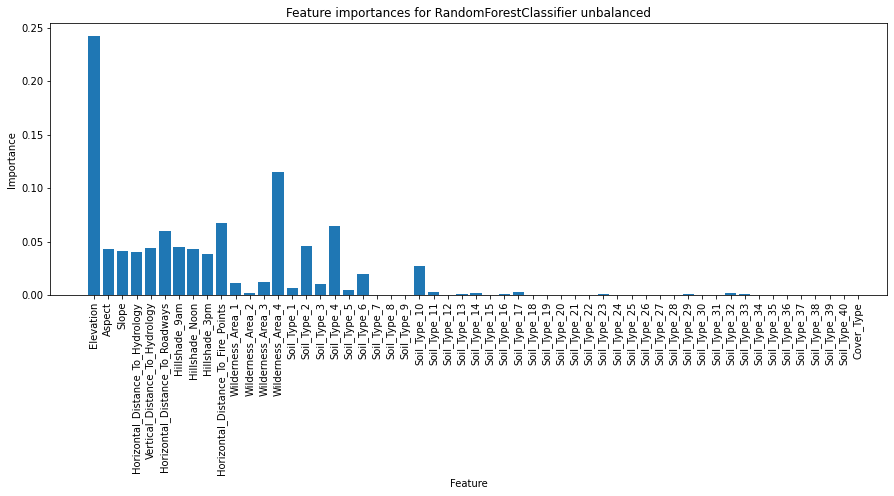

In [52]:
plt.figure(figsize=(15,5))
plt.title("Feature importances for RandomForestClassifier unbalanced")
plt.bar(range(len(bestUnbalancedRFClassifier.feature_importances_)), bestUnbalancedRFClassifier.feature_importances_)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

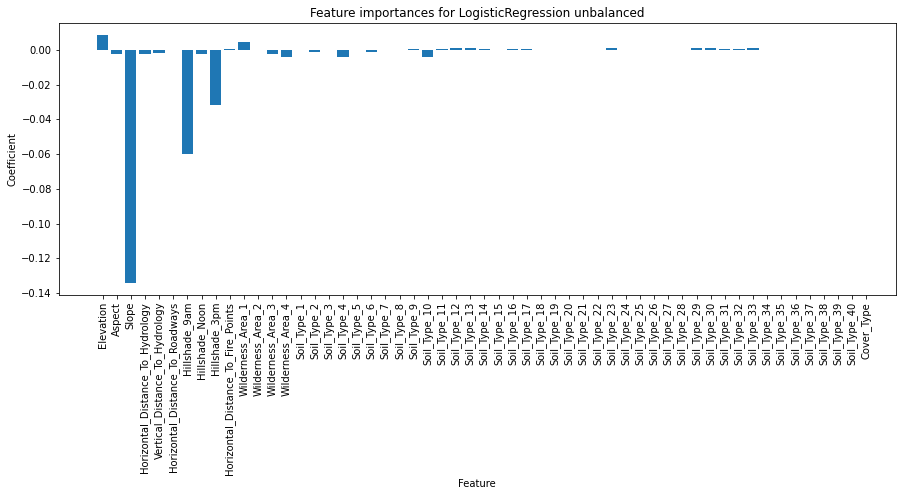

In [53]:
plt.figure(figsize=(15,5))
plt.title("Feature importances for LogisticRegression unbalanced")
plt.bar(range(len(bestUnbalancedLogRegModel.coef_[0])), bestUnbalancedLogRegModel.coef_[0])
plt.xticks(range(len(columns)),columns, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.show()

K-блочная стратифицированная проверка для трёх алгоритмов

In [58]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

logReg_scores = cross_val_score(bestLogRegModel, dfX, dfY, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='roc_auc')
print("LogisticRegression AUC scores:", logReg_scores)
print("LogisticRegression Mean AUC score:", logReg_scores.mean())

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

LogisticRegression AUC scores: [0.9764406  0.96595745 0.98010195 0.98043623 0.97203102]
LogisticRegression Mean AUC score: 0.9749934486868785


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [55]:
rf_scores = cross_val_score(bestRFClassifier, dfX, dfY, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='roc_auc')
print("RandomForest AUC scores:", rf_scores)
print("RandomForest Mean AUC score:", rf_scores.mean())

RandomForest AUC scores: [0.9908156  0.98640957 0.98236702 0.98975409 0.98980467]
RandomForest Mean AUC score: 0.9878301916152912


In [59]:
XGB_scores = cross_val_score(bestXGBClassifierModel, dfX, dfY, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='roc_auc')
print("XGB Classifier AUC scores:", XGB_scores)
print("XGB Classifier Mean AUC score:", XGB_scores.mean())

XGB Classifier AUC scores: [0.99117021 0.98736702 0.99075798 0.98891621 0.9886655 ]
XGB Classifier Mean AUC score: 0.9893753845497695
